In [1]:
import pandas as pd
import os
import re
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, ClusterWarning, set_link_color_palette
import matplotlib.pyplot as plt
from warnings import simplefilter

simplefilter("ignore", ClusterWarning)
set_link_color_palette(['C0'])

### Iteration 1 | Parse VCF files to table/dataframe

In [14]:
def read_vcf(file):
    
    """ Reads .vcf file, whose path should be specified as input.
        Returns variant dataframe. """
    
    with open(file, "r") as f:
        
        for line in f:   # Get header line
            if line.startswith('#CHROM'): hd = line; break
                
        hd = hd[1:].strip().split("\t")   # Remove # from CHROM and convert to list
        df = pd.read_csv(f, delimiter='\t', names=hd, comment='#')   # Save vcf as dataframe
        
    return df

In [15]:
file = "./data/test.vcf"
#file = "/home/athena/Desktop/IiSGM-bioinfo-test/data/10105494-0-COL2.combined.hf.SNP.final.vcf"
df = read_vcf(file)
df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10105494-0-COL1
0,MTB_anc,1701,.,T,C,140323.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=0.814;DP=144;Ex...,GT:AD:DP:GQ:PL,"1/1:0,144:144:99:5088,430,0"
1,MTB_anc,2532,.,C,T,47660.33,PASS,AC=2;AF=1.00;AN=2;DP=58;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,58:58:99:2019,173,0"
2,MTB_anc,8040,.,G,A,88799.33,PASS,AC=2;AF=1.00;AN=2;DP=90;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,90:90:99:3042,269,0"
3,MTB_anc,9143,.,C,T,38105.33,PASS,AC=2;AF=1.00;AN=2;DP=50;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,50:50:99:1780,150,0"
4,MTB_anc,13460,.,G,A,33355.32,PASS,AC=2;AF=1.00;AN=2;DP=37;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,37:37:99:1332,110,0"
...,...,...,...,...,...,...,...,...,...,...
846,MTB_anc,4408923,.,T,C,31503.27,PASS,AC=2;AF=1.00;AN=2;DP=24;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,24:24:72:1|1:4408920_G_A:1080,72,0:4408920"
847,MTB_anc,4408923,.,T,C,31503.27,q10;s50,AC=2;AF=1.00;AN=2;DP=24;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,24:24:72:1"
848,MTB_anc,4408923,.,T,C,31503.27,PASS,AC=2;AF=1.00;AN=2;DP=24;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PGT:PID:PL:PS,"0/1:0,24:24:72:"
849,MTB_anc,4408923,.,T,C,31503.27,PASS,AC=2;AF=1.00;AN=2;DP=24;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:0,24:24:72:"


### Iterations 2 and 5 | Extract relevant information from parsed VCF and Include INDELS

Remove FILTER != PASS or end col indicating heterozigois (0/1, 1/2, ...). 
Yo creo que los indels deberían contar como una mutación más, es decir un 1 en la matriz de 1/0. En el caso de que provoquen frameshift se verá en los siguientes nucleótidos?

In [16]:
def filter_vcf(df):
    
    """ Removes low quality variants and wrongly assigned 
        heterozygous variants. Returns filtered dataframe. """
    
    f_df = df # Copy dataframe to be filtered
    f_df.drop(f_df[f_df.FILTER != "PASS"].index, inplace=True)   # Drop low quality sites
    for inf in f_df.itertuples():   # Drop "heterozygous"
        l_line = inf[-1]
        if l_line[0] != l_line[2]: f_df.drop(inf[0], inplace=True)   # If the alleles are not equal
    
    return f_df

In [18]:
f_df = filter_vcf(df)
f_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10105494-0-COL1
0,MTB_anc,1701,.,T,C,140323.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=0.814;DP=144;Ex...,GT:AD:DP:GQ:PL,"1/1:0,144:144:99:5088,430,0"
1,MTB_anc,2532,.,C,T,47660.33,PASS,AC=2;AF=1.00;AN=2;DP=58;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,58:58:99:2019,173,0"
2,MTB_anc,8040,.,G,A,88799.33,PASS,AC=2;AF=1.00;AN=2;DP=90;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,90:90:99:3042,269,0"
3,MTB_anc,9143,.,C,T,38105.33,PASS,AC=2;AF=1.00;AN=2;DP=50;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,50:50:99:1780,150,0"
4,MTB_anc,13460,.,G,A,33355.32,PASS,AC=2;AF=1.00;AN=2;DP=37;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,37:37:99:1332,110,0"
...,...,...,...,...,...,...,...,...,...,...
842,MTB_anc,4397324,.,G,C,22342.17,PASS,AC=2;AF=1.00;AN=2;DP=19;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,19:19:57:784,57,0"
843,MTB_anc,4407588,.,C,T,45587.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=1.81;DP=65;Exce...,GT:AD:DP:GQ:PL,"1/1:0,65:65:99:2098,194,0"
844,MTB_anc,4408156,.,A,C,43801.33,PASS,AC=2;AF=1.00;AN=2;DP=65;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,65:65:99:2470,195,0"
845,MTB_anc,4408920,.,G,A,31138.27,PASS,AC=2;AF=1.00;AN=2;DP=24;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,24:24:72:1|1:4408920_G_A:1080,72,0:4408920"


### Iteration 3 | Combine present SNP into a presence matrix

In [6]:
def presence_matrix(direct):
    
    """ Reads all .vcf files from specified path.
        Returns presence/absence matrix with mutations (POS_REF_ALT)
        as columns and organism IDs as rows. """
    
    dir_l = [direct + f for f in os.listdir(direct) if f.endswith(".vcf")] # Get vcf files in directory
    
    d = defaultdict(dict)   # Create empty mutation dict
    for file in dir_l:   # Read and filter mutations
        df = read_vcf(file)
        f_df = filter_vcf(df)
        d = d_mut(f_df, d)   # Add items to mutation dict
        
    pr_mat = pd.DataFrame(d).fillna(0).astype(int)   # Dict to 1/0 matrix
    
    return pr_mat

In [7]:
def d_mut(df, d):
    
    """ From variant dataframe, adds entry to 
        mutation dictionary --> d[mutation][organism] = 1. """
    
    org = df.columns[-1]   # Get sample id
    mut = list(df[["POS", "REF", "ALT"]].apply(lambda x: 
                                               '_'.join(x.astype(str)), axis=1))   # List of mutation ids (POS_REF_ALT) in organism
    for m in mut: d[m][org] = 1   # Add items to dict
    
    return d

In [8]:
direct = "/home/athena/Desktop/IiSGM-bioinfo-test/data/"
pr_mat = presence_matrix(direct)
pr_mat

In [10]:
"""
# para ver cuántos snp hay
l=[]
for i in d.keys():
    l = l + list(d[i].keys())

# para ver las variantes alternativas
#for i in l:
#    if "," in i: print(i)
        
# inserciones
print("INSERCIONES")
for i in l:
    if re.match(".*_.+_..+", i):
        print(i)
        
# deleciones
print()
print("DELECIONES")
for i in l:
    if re.match(".*_..+_.+", i):
        print(i)
"""

INSERCIONES

DELECIONES


### Iterations 4 and  6 | Calculate the SNP distance between all samples and Represent distance in a phylogenetic tree

¿Qué combinación (métrica, método) debo usar en este caso?

In [25]:
def mut_dist_dnd(pr_mat, metric='jaccard'):
    
    """ Calculates pairwise distance between samples 
        and plots dendrogram of the results. """
    
    linkage_matrix = linkage(pr_mat, metric=metric)   # Pairwise distance according to specified metric
    
    plt.figure(figsize=(10, 7))
    plt.grid(axis='x')
    dnd = dendrogram(linkage_matrix,   # Plot dendrogram
               labels = pr_mat.index,
               orientation='left')
    plt.title("Distance dendrogram - " + metric, fontsize=15)
    plt.show()
    
    return linkage_matrix

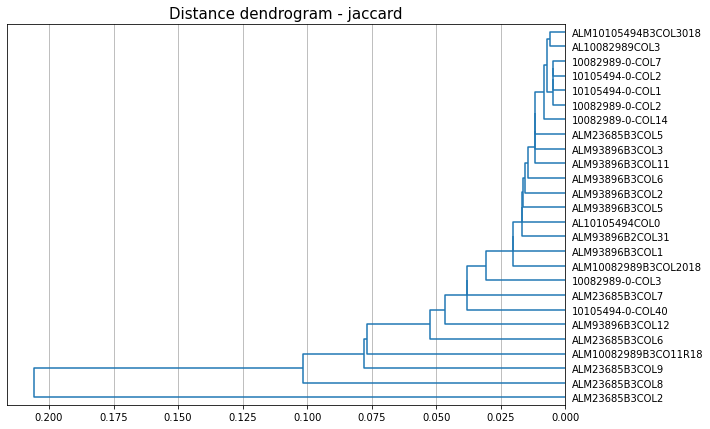

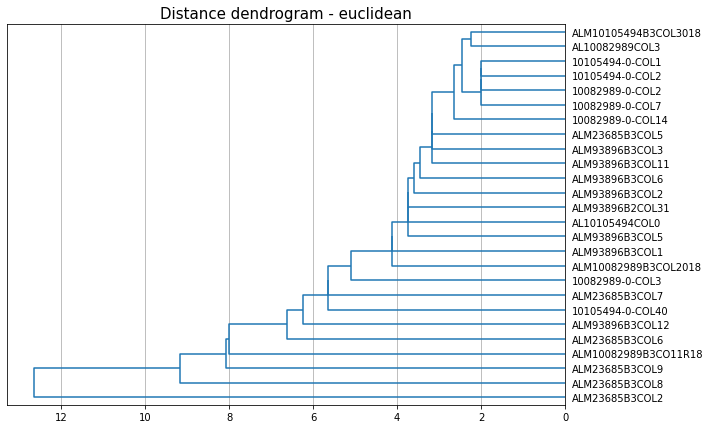

In [26]:
dist_mat_jaccard = mut_dist_dnd(pr_mat)   # Jaccard index
dist_mat_eucl = mut_dist_dnd(pr_mat, 'euclidean')   # Euclidean distance